In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

### **Set Constants**

In [24]:
EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
# DATASET_DIR = "/kaggle/input/sugarcane-leaf-disease-dataset"
SEED = 123
BATCH_SIZE = 64
BUFFER_SIZE = 350
FINE_TUNE_POINT = 100
LEARNING_RATE = 0.001

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
DATASET_DIR = '/content/drive/My Drive/arcgis-survey-images'


### **Load Image Datasets**

In [27]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

Found 3289 files belonging to 5 classes.
Using 2632 files for training.
Found 3289 files belonging to 5 classes.
Using 657 files for validation.


In [28]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))


In [29]:
class_names = train_ds.class_names

In [30]:
for example_image, example_label in train_ds.take(1):
  break

print(f"Image Shape: {example_image.shape}")

Image Shape: (64, 128, 128, 3)


### **Split Validation Dataset into a Validation DS and Test DS**

In [31]:
validation_ds = validation_ds.shard(num_shards=2, index=0)
test_ds = validation_ds.shard(num_shards=2, index=1)

### **Visualize a Set of Training Data**

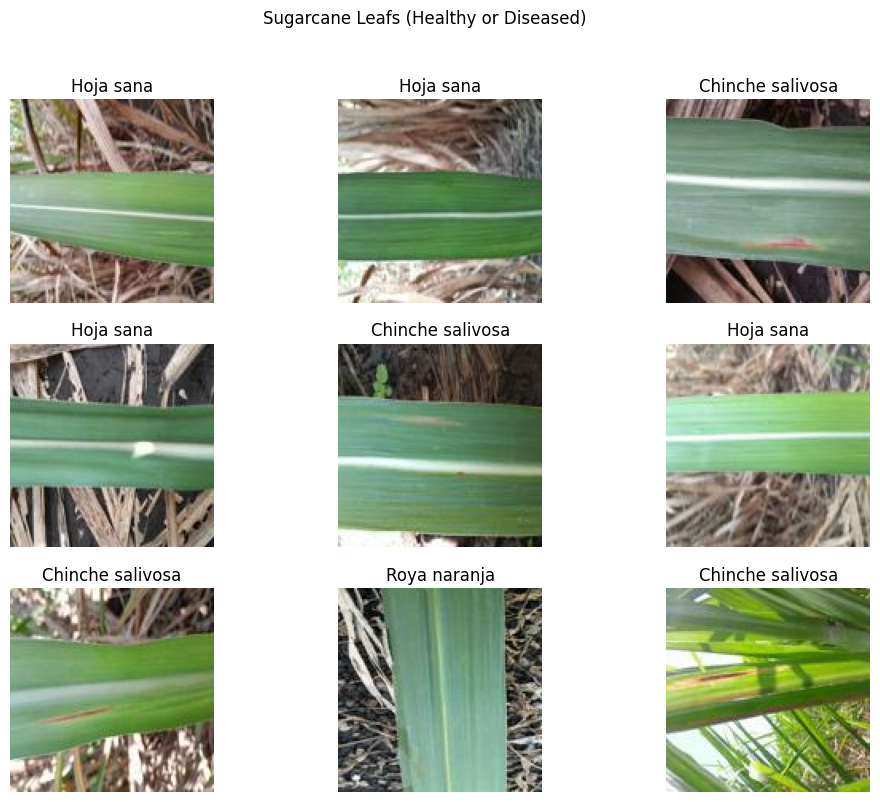

In [32]:
plt.figure(figsize=(12, 9))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.suptitle("Sugarcane Leafs (Healthy or Diseased)")
        plt.axis("off")

In [33]:
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### **Load Base Model**

In [34]:
from tensorflow.keras.applications import MobileNetV2

# Carga del modelo base con MobileNetV2
base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                         include_top=False,
                         weights='imagenet')

# Ajuste de las capas del modelo base
for layer in base_model.layers[:100]:  # Ajusta el número de capas descongeladas
    layer.trainable = False

# Definir el modelo completo con capas adicionales
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(class_names))
])

# Compilar el modelo
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [35]:
for layer in base_model.layers[:FINE_TUNE_POINT]:
  layer.trainable = False

### **Create the Classification Model**

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(class_names))
])

In [37]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### **Fit the Model**

In [38]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 340ms/step - accuracy: 0.6271 - loss: 1.1037 - val_accuracy: 0.4985 - val_loss: 1.8288
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8894 - loss: 0.3628 - val_accuracy: 0.4006 - val_loss: 2.5978
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9100 - loss: 0.2706 - val_accuracy: 0.5193 - val_loss: 3.7390
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9509 - loss: 0.1712 - val_accuracy: 0.5579 - val_loss: 2.3901
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9563 - loss: 0.1273 - val_accuracy: 0.3264 - val_loss: 7.3339
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9499 - loss: 0.1511 - val_accuracy: 0.3947 - val_loss: 6.3451
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9413 - loss: 0.1725 - val_accuracy: 0.3412 - val_loss: 9.3625
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9623 - loss: 0.1380 - val_accuracy: 0.5312 -

### **Classification Report**

Text(0.5, 0, 'Epoch')

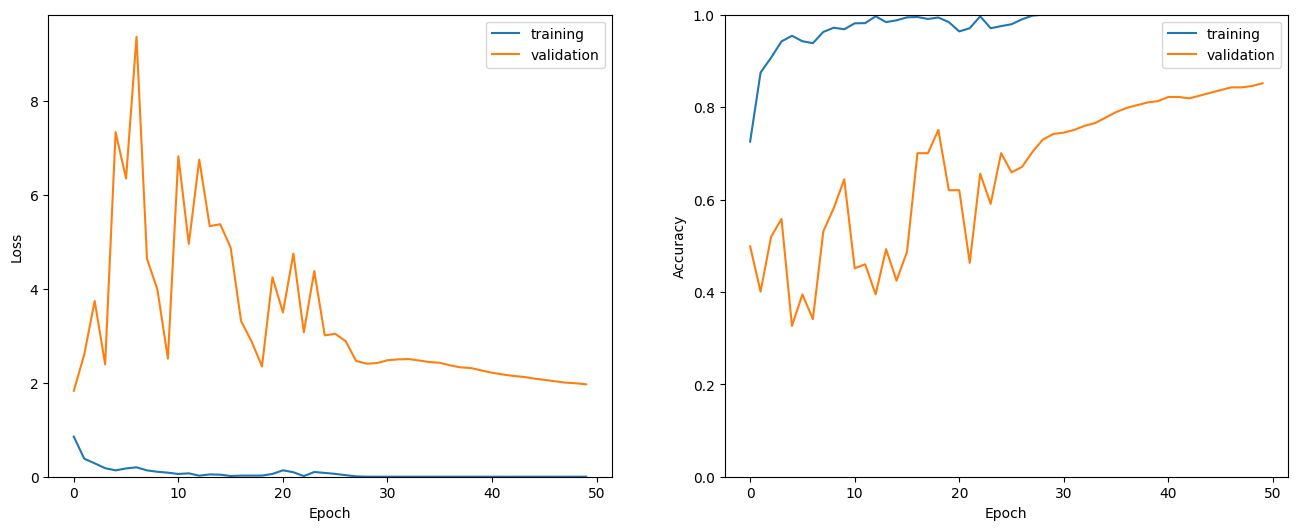

In [39]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [40]:
# Guardar el modelo en formato .keras
model.save('FineTune1.keras')

In [41]:
model.evaluate(test_ds, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 658ms/step - accuracy: 0.9274 - loss: 0.9648


{'accuracy': 0.9172413945198059, 'loss': 0.9412198662757874}

In [42]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


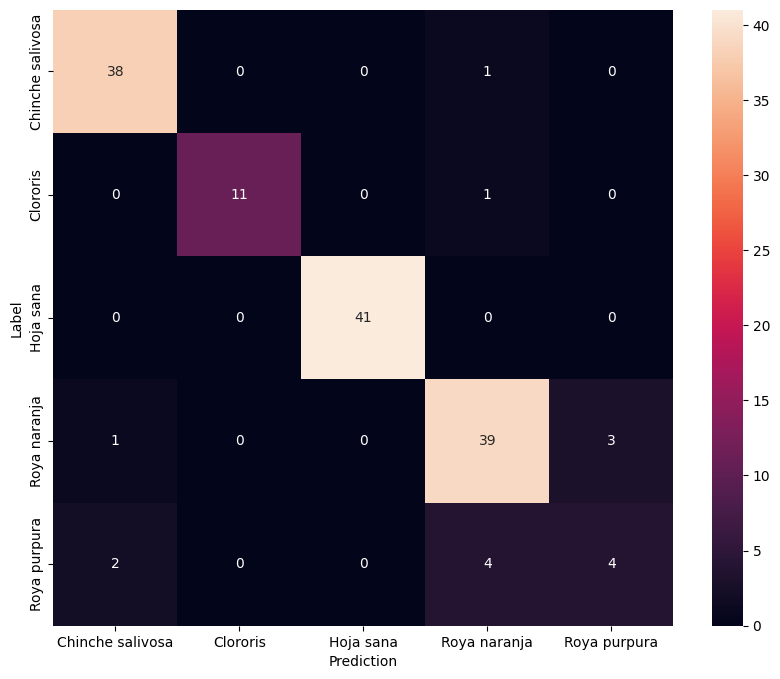

In [43]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9274 - loss: 0.9648
Resultados de evaluación en test set:
accuracy: 0.9172
loss: 0.9412
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Reporte de clasificación:
                  precision    recall  f1-score   support

Chinche salivosa       0.93      0.97      0.95        39
        Clororis       1.00      0.92      0.96        12
       Hoja sana       1.00      1.00      1.00        41
    Roya naranja       0.87      0.91      0.89        43
    Roya purpura       0.57      0.40      0.47        10

        accuracy                           0.92       145
       macro avg       0.87      0.84      0.85       145
    weighted avg       0.91      0.92      0.91       145



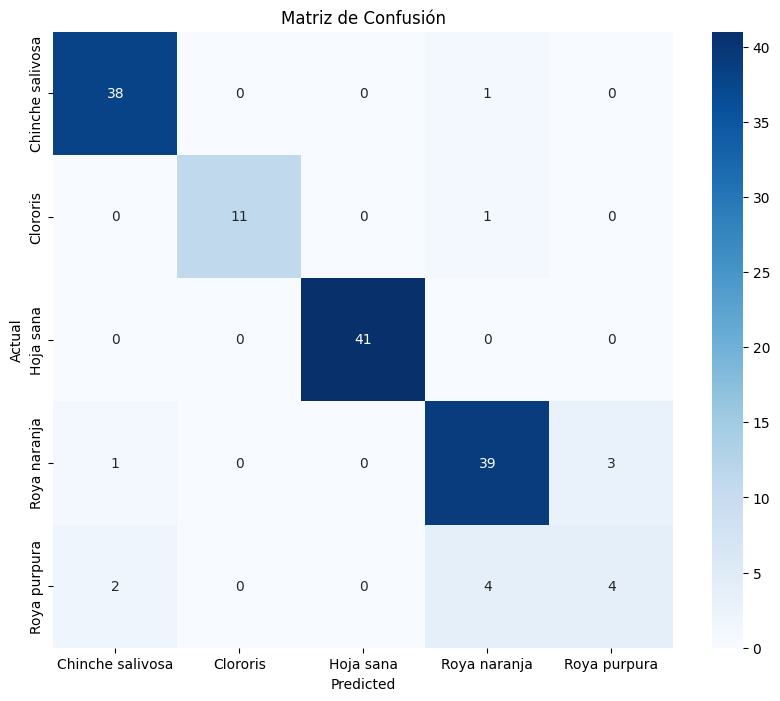

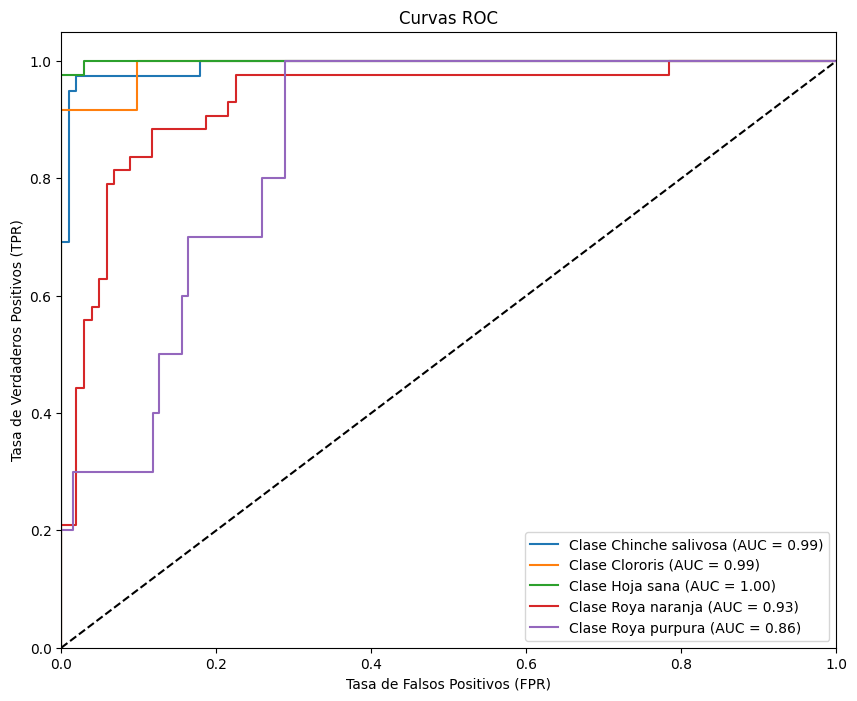

In [44]:

# Evaluación del modelo y visualización de resultados

# Evaluar el modelo en el conjunto de test
test_results = model.evaluate(test_ds, return_dict=True)
print("Resultados de evaluación en test set:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

# Predicción de etiquetas en el conjunto de test
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Reporte de clasificación
from sklearn.metrics import classification_report
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Matriz de confusión
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# Curvas ROC y AUC para cada clase
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
plt.figure(figsize=(10, 8))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.show()
